In [19]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import numpy as np
import itertools
import datetime
import time
import glob
import cv2
import os
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.resnet50 import ResNet50, preprocess_input

### Simple NN

##### Load data

In [20]:
dates = ['24032019', '17042019', '01052019']
labels = ['zeev', 'or', 'ron', 'aviya', 'felix']
TRAIN_AND_VALIDATION_TEST_SPLIT = 0.2
VALID_AND_TEST_SPLIT           = 0.5

In [3]:
# stratified data
x_train = [] 
y_train = []

x_valid = []
y_valid = []

x_test  = []
y_test  = []

In [4]:
def prep_data(dates, labels, x_train, y_train, x_valid, y_valid, x_test, y_test):  
    # for i, l in enumerate(labels):
    for d in dates:
        for i, l in enumerate(labels):
            x_data = []
            y_data = []
            for f in tqdm(glob.glob('../data/frames/{0}/{1}/32/*.png'.format(d, l))):
                x_data.append(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
                y_data.append(i)
            x_train_label, xx_test_label, y_train_label, yy_test_label \
                             = train_test_split(x_data, y_data, test_size=TRAIN_AND_VALIDATION_TEST_SPLIT)
            x_valid_label, x_test_label, y_valid_label, y_test_label \
                         = train_test_split(xx_test_label, yy_test_label, test_size=VALID_AND_TEST_SPLIT)  

            x_train.append(x_train_label)
            y_train.append(y_train_label)
            x_test.append(x_test_label)
            y_test.append(y_test_label)
            x_valid.append(x_valid_label)
            y_valid.append(y_valid_label)

    x_train = list(itertools.chain.from_iterable(x_train))
    y_train = list(itertools.chain.from_iterable(y_train))
    x_test = list(itertools.chain.from_iterable(x_test))
    y_test = list(itertools.chain.from_iterable(y_test))
    x_valid = list(itertools.chain.from_iterable(x_valid))
    y_valid = list(itertools.chain.from_iterable(y_valid))

    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    x_test  = np.asarray(x_test)
    y_test  = np.asarray(y_test)
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)

    x_train= x_train / 255.0, 
    x_valid  = x_valid / 255.0
    x_test = x_test / 255.0
    return x_train, y_train, x_valid, y_valid, x_test, y_test

In [5]:
x_train, y_train, x_valid, y_valid, x_test, y_test = prep_data(dates, labels, x_train, y_train, x_valid, y_valid, x_test, y_test)

100%|██████████| 3000/3000 [00:00<00:00, 6056.77it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 30000/30000 [00:05<00:00, 5467.58it/s]
0it [00:00, ?it/s]
100%|██████████| 22000/22000 [00:03<00:00, 5881.42it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 21000/21000 [00:03<00:00, 5673.06it/s]


In [6]:
def show_sample(idx):
    plt.imshow(x_data[idx])
    plt.show()

In [8]:
#Check if stratified

# print(len(y_train),len(y_valid),len(y_test))

# unique, counts = np.unique(y_valid, return_counts=True)
# np.asarray((unique, counts)).T

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32)),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(labels), activation=tf.nn.softmax)
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 527,365
Trainable params: 527,365
Non-trainable params: 0
_________________________________________________________________


In [7]:
def set_curr_time():
    dt = datetime.datetime.now()
    curr_dt = '{0}{1}{2}_{3}_{4}'.format(datetime.datetime.now().year, datetime.datetime.now().month,
                                       datetime.datetime.now().day, datetime.datetime.now().hour,
                                      datetime.datetime.now().minute)
    return curr_dt

In [33]:
conf_list = [
#     [32, 512, 0.2],
#     [32, 256, 0.2],
    [32, 256, 0.3,128,0.3]
]

In [34]:
def custom_model(config, model_weights=None):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(config[0], config[0])),
        tf.keras.layers.Dense(config[1], kernel_regularizer=keras.regularizers.l2(0.0001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation(activation=tf.nn.selu),
        tf.keras.layers.Dropout(config[2]),
        tf.keras.layers.Dense(config[3],kernel_regularizer=keras.regularizers.l2(0.0001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation(activation=tf.nn.selu),
        tf.keras.layers.Dropout(config[4]),        
        tf.keras.layers.Dense(len(labels), activation=tf.nn.softmax)
    ])
    if model_weights is not None:
        print('loading pre-trained model')
        model.load_weights(model_weights, by_name=True)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [35]:
def run_custom_training(conf_list, x_train, y_train, x_valid, y_valid, x_test, y_test, model_path_prefix=None, model_weights=None):
    for conf in conf_list:
        curr_dt = set_curr_time()
        tb_callback = tf.keras.callbacks.TensorBoard(log_dir='../logs/{0}'.format(curr_dt), histogram_freq=0, write_graph=True)
        model = custom_model(conf, model_weights)
        tic = time.time()
        model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=256,
                  epochs=50, callbacks=[tb_callback])
        toc = time.time()
        print('---Test loss & accuracy---')
        model.evaluate(x_test, y_test)
        print('Training time:{}'.format(toc-tic))

#         if model_path_prefix is None:
#             model.save('../models/{0}_{1}.h5'.format(conf, curr_dt))
#         else:
#             model.save('../models/{0}_{1}_{2}.h5'.format(model_path_prefix, conf, curr_dt))
            
run_custom_training(conf_list, x_train, y_train, x_valid, y_valid, x_test, y_test, model_path_prefix=None, model_weights=None)            

Train on 113600 samples, validate on 14200 samples
Epoch 1/50
113600/113600 [==============================] - 35s 308us/sample - loss: 1.3082 - acc: 0.4819 - val_loss: 1.5950 - val_acc: 0.3821
Epoch 2/50
113600/113600 [==============================] - 34s 301us/sample - loss: 1.1172 - acc: 0.5623 - val_loss: 1.3033 - val_acc: 0.4651
Epoch 3/50
113600/113600 [==============================] - 28s 244us/sample - loss: 1.0739 - acc: 0.5832 - val_loss: 1.0775 - val_acc: 0.5842
Epoch 4/50
113600/113600 [==============================] - 31s 269us/sample - loss: 1.0459 - acc: 0.5968 - val_loss: 1.2806 - val_acc: 0.4934
Epoch 5/50
113600/113600 [==============================] - 35s 307us/sample - loss: 1.0206 - acc: 0.6094 - val_loss: 1.0724 - val_acc: 0.5854
Epoch 6/50
113600/113600 [==============================] - 32s 284us/sample - loss: 0.9998 - acc: 0.6183 - val_loss: 1.0624 - val_acc: 0.5849
Epoch 7/50
113600/113600 [==============================] - 34s 301us/sample - loss: 0.9785

## resnet 50 model

In [4]:
CLASSES = 5

# stratified data
x_train = [] 
y_train = []

x_valid = []
y_valid = []

x_test  = []
y_test  = []

In [ ]:
def prep_data(dates, labels, x_train, y_train, x_valid, y_valid, x_test, y_test):  
    # for i, l in enumerate(labels):
    for d in dates:
        for i, l in enumerate(labels):
            x_data = []
            y_data = []
            for f in tqdm(glob.glob('../data/frames/{0}/{1}/32/*.png'.format(d, l))):
#                 img = cv2.resize(cv2.imread(f, cv2.IMREAD_GRAYSCALE), (224,224))
#                 x = preprocess_input(cv2.resize(cv2.imread(f, cv2.IMREAD_GRAYSCALE), (224,224)))
#                 print(img)
                x_data.append(preprocess_input(cv2.resize(cv2.imread(f, cv2.IMREAD_GRAYSCALE), (224,224))))
                y_data.append(i)
            x_train_label, xx_test_label, y_train_label, yy_test_label \
                             = train_test_split(x_data, y_data, test_size=TRAIN_AND_VALIDATION_TEST_SPLIT)
            x_valid_label, x_test_label, y_valid_label, y_test_label \
                         = train_test_split(xx_test_label, yy_test_label, test_size=VALID_AND_TEST_SPLIT)  

            x_train.append(x_train_label)
            y_train.append(y_train_label)
            x_test.append(x_test_label)
            y_test.append(y_test_label)
            x_valid.append(x_valid_label)
            y_valid.append(y_valid_label)

    x_train = list(itertools.chain.from_iterable(x_train))
    y_train = list(itertools.chain.from_iterable(y_train))
    x_test = list(itertools.chain.from_iterable(x_test))
    y_test = list(itertools.chain.from_iterable(y_test))
    x_valid = list(itertools.chain.from_iterable(x_valid))
    y_valid = list(itertools.chain.from_iterable(y_valid))

    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    x_test  = np.asarray(x_test)
    y_test  = np.asarray(y_test)
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)

    x_train= x_train / 255.0, 
    x_valid  = x_valid / 255.0
    x_test = x_test / 255.0
    return x_train, y_train, x_valid, y_valid, x_test, y_test

x_train, y_train, x_valid, y_valid, x_test, y_test = prep_data(dates, labels, x_train, y_train, x_valid, y_valid, x_test, y_test)

 43%|████▎     | 1286/3000 [01:46<5:52:48, 12.35s/it]

In [34]:
def run_custom_training(x_train, y_train, x_valid, y_valid, x_test, y_test, model_path_prefix=None):
        curr_dt = set_curr_time()
        tb_callback = tf.keras.callbacks.TensorBoard(log_dir='../logs/{0}'.format(curr_dt), histogram_freq=0, write_graph=True)
        tic = time.time()
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks=[tb_callback])
        toc = time.time()
        print('---Test loss & accuracy---')
        model.evaluate(x_test, y_test)
        print('Training time:{}'.format(toc-tic))

#         if model_path_prefix is None:
#             model.save('../models/{0}_{1}.h5'.format(conf, curr_dt))
#         else:
#             model.save('../models/{0}_{1}_{2}.h5'.format(model_path_prefix, conf, curr_dt))
            
run_custom_training( x_train, y_train, x_valid, y_valid, x_test, y_test, model_path_prefix=None)            

IndexError: list index out of range

## Create confusion matrix

In [ ]:
# c_model = tf.keras.models.load_model('../models/[32, 512, 0.1]_201953_12_56.h5')

In [ ]:
# c_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256,
#               epochs=50, callbacks=[tb_callback])

In [ ]:
# c_model.evaluate(x_test, y_test)

In [ ]:
# Evaluate all the models
# for model_path in glob.glob('../models/*.h5'):
#     print(model_path)
#     best_loaded = tf.keras.models.load_model(model_path)
#     best_loaded.evaluate(x_test, y_test)

In [85]:
best_loaded = tf.keras.models.load_model('../models/[32, 512, 0.1]_201953_12_56.h5')
test_predictions = best_loaded.predict(x_test)

In [87]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, np.argmax(test_predictions,axis=1))
confusion

array([[1217,    0,    0,    0,    0,    0,    0],
       [   0, 3174,  309,  879,    0,  645,    0],
       [   0,  177, 5386,  443,    0,  630,    0],
       [   0,  569,  666, 4133,    0, 1290,    0],
       [   0,    0,    0,    0, 1153,    0,    0],
       [   0,  289,  546,  924,    0, 4137,    0],
       [   0,    0,    0,    0,    0,    0,  633]])

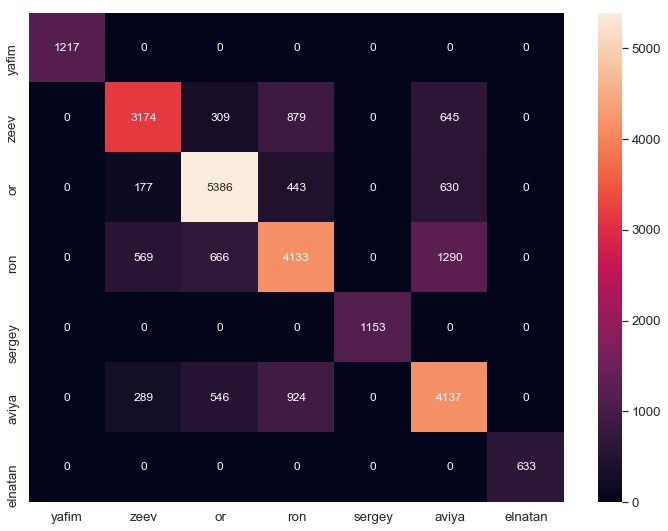

In [104]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion, labels, labels)
plt.figure(figsize = (12, 9))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, fmt='.5g', annot_kws={"size": 12})

In [105]:
df_cm

,yafim,zeev,or,ron,sergey,aviya,elnatan
yafim,1217,0,0,0,0,0,0
zeev,0,3174,309,879,0,645,0
or,0,177,5386,443,0,630,0
ron,0,569,666,4133,0,1290,0
sergey,0,0,0,0,1153,0,0
aviya,0,289,546,924,0,4137,0
elnatan,0,0,0,0,0,0,633
